# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b8892584f8a1638cb354ca1eaac330e55e42c976cfd30be1d702e4123ff9db1f
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [8]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [9]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-9-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

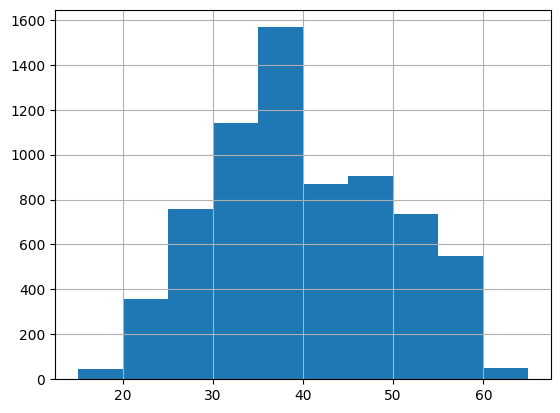

In [10]:
all_df["Age"].hist()

In [11]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [12]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [13]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [14]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

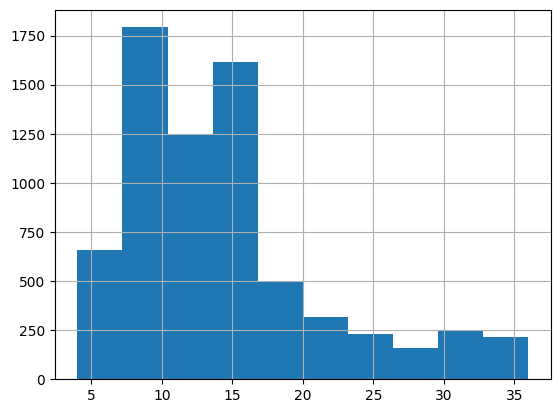

In [15]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [16]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [17]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [18]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [19]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [20]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [21]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [22]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [23]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [24]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [25]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"
    # all_df.loc[i,"ProductPitched"] = 1

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"
    # all_df.loc[i,"ProductPitched"] = 2

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"
    # all_df.loc[i,"ProductPitched"] = 3

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"
    # all_df.loc[i,"ProductPitched"] = 4

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"
    # all_df.loc[i,"ProductPitched"] = 5

  else:
    others.append(i)

In [26]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [27]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [28]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

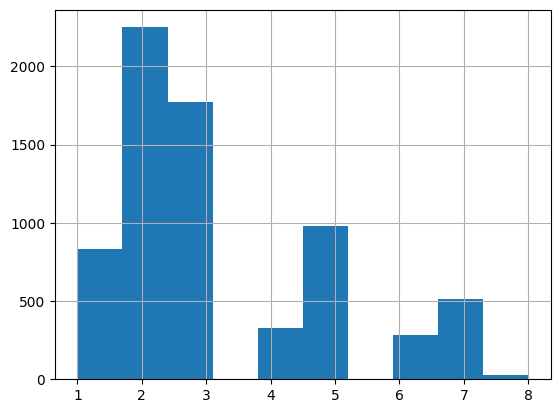

In [29]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [30]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

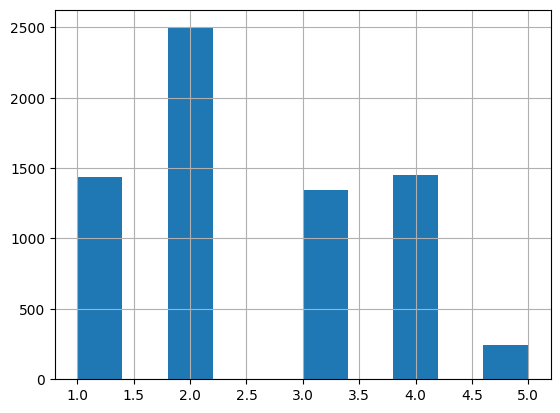

In [31]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [32]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [33]:
# Executive: 取締役、執行役員
# VP: 副社長、本部長
# AVP: 副社長補佐
# Senior Manager: 課長、次長
# Manager: 課長
# col = []

# for i in range(max_row):

#   if(all_df.loc[i,"Designation"] not in col):
#     col.append(all_df.loc[i,"Designation"])

In [34]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [35]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"
    # all_df.loc[i,"Designation"] = 5

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"
    # all_df.loc[i,"Designation"] = 4

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"
    # all_df.loc[i,"Designation"] = 3

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"
    # all_df.loc[i,"Designation"] = 2

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"
    # all_df.loc[i,"Designation"] = 1

In [36]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [37]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

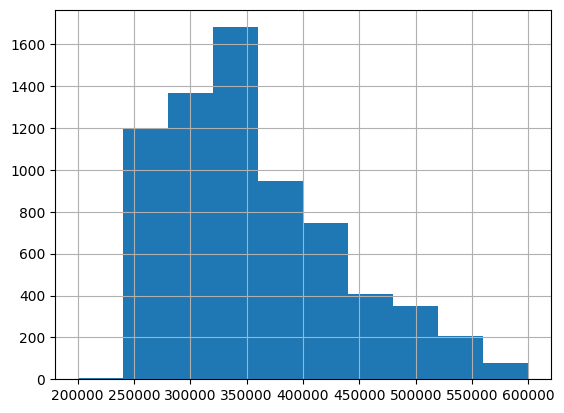

In [38]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [39]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [40]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [41]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [42]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [43]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [44]:
####################
# 新たな特徴を追加 #
####################
# 1. all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]
# 2. all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 3. all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 4. all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]
# 5. all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]
# 6. all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]
# 7. all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]
# 8. all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]
# 9. all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]
# 10. all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]
# 11. all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]
# 12. all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]
# 13. all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]
# 14. all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# 15. all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]
# 16. all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]
# 17. all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]
# 18. all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [45]:
pip install -U scikit-learn

In [46]:
from sklearn.preprocessing import OrdinalEncoder
# oe = preprocessing.OrdinalEncoder()
oe = OrdinalEncoder()
# all_df["Designation_LE"] = oe.fit_transform(all_df["Designation"].values.reshape(-1,1))
# all_df["Occupation_LE"] = oe.fit_transform(all_df["Occupation"].values.reshape(-1,1))
# all_df["Gender_LE"] = oe.fit_transform(all_df["Gender"].values.reshape(-1,1))
# all_df["ProductPitched_LE"] = oe.fit_transform(all_df["ProductPitched"].values.reshape(-1,1))
# all_df["Married_LE"] = oe.fit_transform(all_df["Married"].values.reshape(-1,1))
# all_df["TypeofContact_LE"] = oe.fit_transform(all_df["TypeofContact"].values.reshape(-1,1))

#------------------------------------------------------------------------------------
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Designation"]
  if(term=="Executive"):
    all_df.loc[i,"Designation_LE"] = 5
  elif(term=="VP"):
    all_df.loc[i,"Designation_LE"] = 4
  elif(term=="AVP"):
    all_df.loc[i,"Designation_LE"] = 3
  elif(term=="Senior Manager"):
    all_df.loc[i,"Designation_LE"] = 2
  elif(term=="Manager"):
    all_df.loc[i,"Designation_LE"] = 1

#------------------------------------------------------------------------------------
# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Occupation"]
  if(term=="Large Business"):
    all_df.loc[i,"Occupation_LE"] = 3
  elif(term=="Small Business"):
    all_df.loc[i,"Occupation_LE"] = 2
  elif(term=="Salaried"):
    all_df.loc[i,"Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

#------------------------------------------------------------------------------------
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Gender"]
  if(term=="Female"):
    all_df.loc[i,"Gender_LE"] = 2
  elif(term=="Male"):
    all_df.loc[i,"Gender_LE"] = 1

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"ProductPitched"]
  if(term=="King"):
    all_df.loc[i,"ProductPitched_LE"] = 5
  elif(term=="SuperDeluxe"):
    all_df.loc[i,"ProductPitched_LE"] = 4
  elif(term=="Deluxe"):
    all_df.loc[i,"ProductPitched_LE"] = 3
  elif(term=="Standard"):
    all_df.loc[i,"ProductPitched_LE"] = 2
  elif(term=="Basic"):
    all_df.loc[i,"ProductPitched_LE"] = 1

#------------------------------------------------------------------------------------
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Married"]
  if(term=="Married"):
    all_df.loc[i,"Married_LE"] = 3
  elif(term=="Divorce"):
    all_df.loc[i,"Married_LE"] = 2
  elif(term=="Single"):
    all_df.loc[i,"Married_LE"] = 1

# 「TypeofContact」をラベルエンコード-----------------------------
all_df["TypeofContact_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"TypeofContact"]
  if(term=="Company Invited"):
    all_df.loc[i,"TypeofContact_LE"] = 2
  elif(term=="Self Enquiry"):
    all_df.loc[i,"TypeofContact_LE"] = 1
#-----------------------------------------------------------------

# 1.「Age」×「MonthlyIncome」 (若年高収入 or 高齢低収入)
all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]

# 2.「MonthlyIncome」×「CityTier」 (地域と収入のミスマッチ度)
all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]

# 3.「Designation」×「MonthlyIncome」 (実際の報酬と役職の一致度(過小/過大評価)
all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]

# 4.「Occupation」×「CarHolder」 (経済属性の組み合わせ)
all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]

# 5.「Occupation」×「DurationOfPitch」 (ターゲット層ごとの営業効果の違い)
all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]

# 6.「Gender」×「ProductPitched」 (商品嗜好の違いを反映)
all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]

# 7.「Married」×「NumofChild」 (家庭環境の圧縮表現)
all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]

# 8.「Married」×「NumberOfFollowups」 (家族持ち層のフォロー行動の傾向分析)
all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]

# 9.「NumberOfTrips」×「PreferredPropertyStar」 (旅行慣れ層の嗜好)
all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]

# 10.「Passport」×「CitytTier」 (国際経験と居住地との関係性)
all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]

# 11.「PrefferedPropertyStar」×「PitchSatisfactionScore」 (高級志向と満足度の関係性)
all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]

# 12.「ProductPitched」×「NumberOfTrips」 (リピーターに対する商品設計の効き方)
all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]

# 13.「TypeofContact」×「NumberOfFollowups」 (コンタクトチャネルの最適性分析)
all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]

# 14.「DurationPitched」×「PitchSatisfactionScore」 (営業時間と結果の相関分析)
all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]

# 15.「TypeofContact」×「Age」 (高齢層に対する適切なチャネル分析)
all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]

# 16.(「MonthlyIncome」 ÷ 「CityTier」) × NumberOfTrips = 地域あたり可処分所得の旅行傾向
all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]

# 17.「Age」×「PitchSatisfactionScore」×「NumberOfFollowups」 = 長期的関係性の影響
all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]

# 18.「NumofChild」×「PreferredPropertyStar」 = 家族連れの高級志向傾向の抽出
all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [47]:
# 使用済みのラベルは抹消する
all_df = all_df.drop("Designation_LE", axis=1)
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)
all_df = all_df.drop("ProductPitched_LE", axis=1)
all_df = all_df.drop("Married_LE", axis=1)
all_df = all_df.drop("TypeofContact_LE", axis=1)

In [48]:
# 重要度の低いラベルは抹消する
# all_df = all_df.drop("Married_times_NumChild", axis=1)
# all_df = all_df.drop("NumTrips_times_PropStar", axis=1)
# all_df = all_df.drop("Contact_times_NumFollow", axis=1)
# all_df = all_df.drop("NumChild_times_PropStar", axis=1)
# all_df = all_df.drop("TypeofContact", axis=1)
# all_df = all_df.drop("CarHolder", axis=1)
# all_df = all_df.drop("Gender", axis=1)

In [49]:
# 1. all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]
# 2. all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 3. all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 4. all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]
# 5. all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]
# 6. all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]
# 7. all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]
# 8. all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]
# 9. all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]
# 10. all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]
# 11. all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]
# 12. all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]
# 13. all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]
# 14. all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# 15. all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]
# 16. all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]
# 17. all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]
# 18. all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [50]:
# 取り除く変数
RMV = ["id","ProdTaken"]

# 使用する変数を制限
FEATURES = ["Age",
            "TypeofContact",
            "CityTier","DurationOfPitch","Occupation",
            "Gender",
            "NumberOfPersonVisiting","NumberOfFollowups","ProductPitched",
            "PreferredPropertyStar","NumberOfTrips","Passport","PitchSatisfactionScore","MonthlyIncome",
            "CarHolder",
            "Married","NumofChild","Designation",
            "Age_times_Income","Income_times_Tier","Desig_times_Income","Occu_times_Car","Occu_times_DurPitch","Gen_times_ProPitch",
            "Married_times_NumChild",
            "Married_times_NumFollow",
            "NumTrips_times_PropStar",
            "Pass_times_Tier","PropStar_times_Satisfac",
            "ProPitch_times_Trip",
            "Contact_times_NumFollow",
            "DurPitch_times_Satisfac","Contact_times_Age","Income_times_Tier_by_Trip",
            "Age_times_Satisfac_times_NumFollow",
            "NumChild_times_PropStar",
            "ProdTaken"]

# FEATURES = ["Age","TypeofContact","CityTier","DurationOfPitch","Occupation","Gender","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched",
#             "PreferredPropertyStar","NumberOfTrips","Passport","PitchSatisfactionScore","MonthlyIncome","CarHolder","Married","NumofChild","Designation",
#             "Age_times_Income","Income_times_Tier","Desig_times_Income","Occu_times_Car","Occu_times_DurPitch","Gen_times_ProPitch",
#             "Married_times_NumChild","Married_times_NumFollow","NumTrips_times_PropStar","Pass_times_Tier","PropStar_times_Satisfac",
#             "ProPitch_times_Trip","Contact_times_NumFollow","DurPitch_times_Satisfac","Contact_times_Age","Income_times_Tier_by_Trip",
#             "Age_times_Satisfac_times_NumFollow","NumChild_times_PropStar",
#             "ProdTaken"]


TARGET = "ProdTaken"

In [51]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [52]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [53]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)

<ipython-input-53-6f97bd2ef6e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)


In [54]:
# one-hot
# all_df2 = pd.get_dummies(all_df2, columns=CATS)

In [55]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [56]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [57]:
FEATURES = test.columns

In [96]:
# import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
# from xgboost import XGBRegressor, XGBClassifier
# import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7310002414300506, # 7回
    'num_leaves': 9, # 20回
    'bagging_fraction': 0.46766930795838424,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    'lambda_l1': 2.5822011957418005,
    'lambda_l2': 7.210420837783116,
    'min_data_in_leaf': 47,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [97]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.918255	valid's auc: 0.837204
#########################
### Fold 2
#########################
[100]	train's auc: 0.934075	valid's auc: 0.799664
#########################
### Fold 3
#########################
[100]	train's auc: 0.927116	valid's auc: 0.829429
CPU times: user 2.28 s, sys: 171 ms, total: 2.45 s
Wall time: 541 ms


In [98]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8251275702342397


In [99]:
# importanceを表示する
importance = pd.DataFrame(models[1].feature_importance(importance_type="gain"),
                          index=test.columns,columns=['importance'])
importance = importance.sort_values("importance", ascending=False)
display(importance)

,importance
Gen_times_ProPitch,74.612921
MonthlyIncome,58.629365
Age_times_Income,58.263666
ProductPitched,52.138700
Passport,38.443053
Married,26.663736
Pass_times_Tier,25.758914
Income_times_Tier,17.022012
Age,16.790142
Desig_times_Income,15.914036


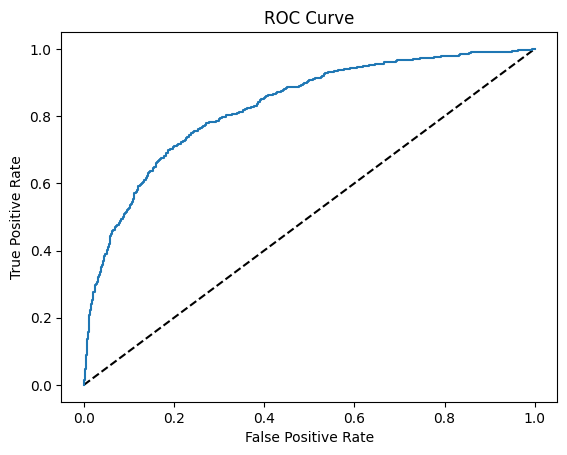

In [62]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [63]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.3 MB/s eta 0:00:00


In [102]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      # 'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=7)

[I 2025-05-19 13:14:26,165] A new study created in memory with name: no-name-fd89bee6-59b8-4906-8ddf-a22ebf347fc4
<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.998679	valid's auc: 0.780909
#########################
### Fold 2
#########################
[100]	train's auc: 0.998625	valid's auc: 0.761477
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:27,051] Trial 0 finished with value: 0.7971848470502158 and parameters: {'feature_fraction': 0.5906174748119287}. Best is trial 0 with value: 0.7971848470502158.


[100]	train's auc: 0.998849	valid's auc: 0.785899
#########################
### Fold 1
#########################


<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998773	valid's auc: 0.778824
#########################
### Fold 2
#########################
[100]	train's auc: 0.998467	valid's auc: 0.762045
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:27,882] Trial 1 finished with value: 0.8029298787376666 and parameters: {'feature_fraction': 0.4996425832723157}. Best is trial 1 with value: 0.8029298787376666.


[100]	train's auc: 0.998787	valid's auc: 0.787199
#########################
### Fold 1
#########################


<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.99814	valid's auc: 0.778408
#########################
### Fold 2
#########################
[100]	train's auc: 0.998475	valid's auc: 0.760897
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:28,733] Trial 2 finished with value: 0.7891140290943521 and parameters: {'feature_fraction': 0.47259563492790385}. Best is trial 1 with value: 0.8029298787376666.


[100]	train's auc: 0.998625	valid's auc: 0.782219
#########################
### Fold 1
#########################


<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998932	valid's auc: 0.779912
#########################
### Fold 2
#########################
[100]	train's auc: 0.999181	valid's auc: 0.759332
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:29,617] Trial 3 finished with value: 0.8062109286736461 and parameters: {'feature_fraction': 0.8591194059253604}. Best is trial 3 with value: 0.8062109286736461.


[100]	train's auc: 0.999088	valid's auc: 0.781636
#########################
### Fold 1
#########################


<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998931	valid's auc: 0.765103
#########################
### Fold 2
#########################
[100]	train's auc: 0.999143	valid's auc: 0.77584
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:32,467] Trial 4 finished with value: 0.7811148306954024 and parameters: {'feature_fraction': 0.9287384029664462}. Best is trial 3 with value: 0.8062109286736461.


[100]	train's auc: 0.999279	valid's auc: 0.782571
#########################
### Fold 1
#########################


<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.99814	valid's auc: 0.778408
#########################
### Fold 2
#########################
[100]	train's auc: 0.998475	valid's auc: 0.760897
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:33,369] Trial 5 finished with value: 0.7891140290943521 and parameters: {'feature_fraction': 0.48416739280660126}. Best is trial 3 with value: 0.8062109286736461.


[100]	train's auc: 0.998625	valid's auc: 0.782219
#########################
### Fold 1
#########################


<ipython-input-102-09b89169c608>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.997948	valid's auc: 0.78848
#########################
### Fold 2
#########################
[100]	train's auc: 0.99838	valid's auc: 0.760057
#########################
### Fold 3
#########################


[I 2025-05-19 13:14:34,315] Trial 6 finished with value: 0.8104391724679627 and parameters: {'feature_fraction': 0.4403157750741276}. Best is trial 6 with value: 0.8104391724679627.


[100]	train's auc: 0.998684	valid's auc: 0.793308


In [103]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.4403157750741276}
[0.8104391724679627]


In [104]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': 0.4403157750741276, # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-19 13:15:16,972] A new study created in memory with name: no-name-ed49902e-6139-40e1-8454-e5c1ff735b84


#########################
### Fold 1
#########################
[100]	train's auc: 0.999749	valid's auc: 0.770335
#########################
### Fold 2
#########################
[100]	train's auc: 0.999909	valid's auc: 0.761731
#########################
### Fold 3
#########################
[100]	train's auc: 0.999761	valid's auc: 0.774124


[I 2025-05-19 13:15:18,262] Trial 0 finished with value: 0.8046568179128246 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.8046568179128246.


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:21,487] Trial 1 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 149}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:22,943] Trial 2 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 113}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:24,397] Trial 3 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 198}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 0.999982	valid's auc: 0.76329
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.745447
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:25,534] Trial 4 finished with value: 0.8009305835010061 and parameters: {'num_leaves': 54}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 0.999991	valid's auc: 0.763533
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.765979
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.734813
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:26,914] Trial 5 finished with value: 0.7974252601168508 and parameters: {'num_leaves': 75}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 1	valid's auc: 0.767602
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:28,354] Trial 6 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 117}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:29,907] Trial 7 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 129}. Best is trial 0 with value: 0.8046568179128246.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 0.998893	valid's auc: 0.78616
#########################
### Fold 2
#########################
[100]	train's auc: 0.999208	valid's auc: 0.771652
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:32,637] Trial 8 finished with value: 0.8100020578013535 and parameters: {'num_leaves': 35}. Best is trial 8 with value: 0.8100020578013535.


[100]	train's auc: 0.999204	valid's auc: 0.76176
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:34,257] Trial 9 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 249}. Best is trial 8 with value: 0.8100020578013535.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 0.836379	valid's auc: 0.836159
[200]	train's auc: 0.845611	valid's auc: 0.837942
[300]	train's auc: 0.851748	valid's auc: 0.837803
#########################
### Fold 2
#########################
[100]	train's auc: 0.855807	valid's auc: 0.797613
[200]	train's auc: 0.864818	valid's auc: 0.800752
[300]	train's auc: 0.870804	valid's auc: 0.802882
#########################
### Fold 3
#########################
[100]	train's auc: 0.834463	valid's auc: 0.833069
[200]	train's auc: 0.846	valid's auc: 0.836443


[I 2025-05-19 13:15:35,352] Trial 10 finished with value: 0.8254580961706066 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.8254580961706066.


[300]	train's auc: 0.852724	valid's auc: 0.835289
#########################
### Fold 1
#########################
[100]	train's auc: 0.986771	valid's auc: 0.795676
#########################
### Fold 2
#########################
[100]	train's auc: 0.989001	valid's auc: 0.768867
#########################
### Fold 3
#########################
[100]	train's auc: 0.989548	valid's auc: 0.794419


[I 2025-05-19 13:15:36,019] Trial 11 finished with value: 0.8070548962222533 and parameters: {'num_leaves': 19}. Best is trial 10 with value: 0.8254580961706066.


#########################
### Fold 1
#########################
[100]	train's auc: 0.93552	valid's auc: 0.828908
#########################
### Fold 2
#########################
[100]	train's auc: 0.942074	valid's auc: 0.794824
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:36,590] Trial 12 finished with value: 0.8198425176728823 and parameters: {'num_leaves': 8}. Best is trial 10 with value: 0.8254580961706066.


[100]	train's auc: 0.93977	valid's auc: 0.818832
#########################
### Fold 1
#########################
[100]	train's auc: 0.907376	valid's auc: 0.825845
#########################
### Fold 2
#########################
[100]	train's auc: 0.925349	valid's auc: 0.801676


[I 2025-05-19 13:15:37,136] Trial 13 finished with value: 0.8184632527787044 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.8254580961706066.


[200]	train's auc: 0.955731	valid's auc: 0.794154
#########################
### Fold 3
#########################
[100]	train's auc: 0.919847	valid's auc: 0.82083
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.763737
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.745091
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:38,526] Trial 14 finished with value: 0.799675728165786 and parameters: {'num_leaves': 80}. Best is trial 10 with value: 0.8254580961706066.


[100]	train's auc: 1	valid's auc: 0.771154
#########################
### Fold 1
#########################
[100]	train's auc: 0.877191	valid's auc: 0.839978
#########################
### Fold 2
#########################
[100]	train's auc: 0.897128	valid's auc: 0.803078


[I 2025-05-19 13:15:39,056] Trial 15 finished with value: 0.8258467919818376 and parameters: {'num_leaves': 4}. Best is trial 15 with value: 0.8258467919818376.


#########################
### Fold 3
#########################
[100]	train's auc: 0.884331	valid's auc: 0.831451
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.770565
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.752879
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:40,577] Trial 16 finished with value: 0.8000879609206039 and parameters: {'num_leaves': 174}. Best is trial 15 with value: 0.8258467919818376.


[100]	train's auc: 1	valid's auc: 0.767766
#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.757471
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.741121
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:41,929] Trial 17 finished with value: 0.7995694756775951 and parameters: {'num_leaves': 78}. Best is trial 15 with value: 0.8258467919818376.


[100]	train's auc: 1	valid's auc: 0.754175
#########################
### Fold 1
#########################
[100]	train's auc: 0.999982	valid's auc: 0.76329
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.745447
#########################
### Fold 3
#########################


[I 2025-05-19 13:15:45,006] Trial 18 finished with value: 0.8009305835010061 and parameters: {'num_leaves': 54}. Best is trial 15 with value: 0.8258467919818376.


[100]	train's auc: 0.999991	valid's auc: 0.763533
#########################
### Fold 1
#########################
[100]	train's auc: 0.836379	valid's auc: 0.836159
[200]	train's auc: 0.845611	valid's auc: 0.837942
[300]	train's auc: 0.851748	valid's auc: 0.837803
#########################
### Fold 2
#########################
[100]	train's auc: 0.855807	valid's auc: 0.797613
[200]	train's auc: 0.864818	valid's auc: 0.800752
[300]	train's auc: 0.870804	valid's auc: 0.802882
#########################
### Fold 3
#########################
[100]	train's auc: 0.834463	valid's auc: 0.833069
[200]	train's auc: 0.846	valid's auc: 0.836443


[I 2025-05-19 13:15:45,910] Trial 19 finished with value: 0.8254580961706066 and parameters: {'num_leaves': 2}. Best is trial 15 with value: 0.8258467919818376.


[300]	train's auc: 0.852724	valid's auc: 0.835289


In [105]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 4}
[0.8258467919818376]


In [107]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': 0.4403157750741276, # 7回
      'num_leaves': 4, # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-05-19 13:17:10,426] A new study created in memory with name: no-name-93bd3a1e-12be-4612-8630-66c11388184c


#########################
### Fold 1
#########################
[100]	train's auc: 0.881407	valid's auc: 0.836395
#########################
### Fold 2
#########################
[100]	train's auc: 0.897342	valid's auc: 0.793501
[200]	train's auc: 0.925905	valid's auc: 0.791936
#########################
### Fold 3
#########################


[I 2025-05-19 13:17:11,123] Trial 0 finished with value: 0.8247829221317209 and parameters: {'bagging_fraction': 0.7057658725217282, 'bagging_freq': 1}. Best is trial 0 with value: 0.8247829221317209.


[100]	train's auc: 0.888839	valid's auc: 0.834123
#########################
### Fold 1
#########################
[100]	train's auc: 0.879474	valid's auc: 0.834099
#########################
### Fold 2
#########################
[100]	train's auc: 0.897152	valid's auc: 0.802471
#########################
### Fold 3
#########################


[I 2025-05-19 13:17:11,655] Trial 1 finished with value: 0.8253605859757476 and parameters: {'bagging_fraction': 0.9175171590443917, 'bagging_freq': 5}. Best is trial 1 with value: 0.8253605859757476.


[100]	train's auc: 0.888875	valid's auc: 0.839716
[200]	train's auc: 0.919962	valid's auc: 0.823775
#########################
### Fold 1
#########################
[100]	train's auc: 0.874392	valid's auc: 0.829404
#########################
### Fold 2
#########################
[100]	train's auc: 0.896687	valid's auc: 0.801561
#########################
### Fold 3
#########################


[I 2025-05-19 13:17:12,193] Trial 2 finished with value: 0.8229413244170908 and parameters: {'bagging_fraction': 0.5928076903622397, 'bagging_freq': 6}. Best is trial 1 with value: 0.8253605859757476.


[100]	train's auc: 0.88484	valid's auc: 0.825518
#########################
### Fold 1
#########################
[100]	train's auc: 0.883928	valid's auc: 0.841301
#########################
### Fold 2
#########################
[100]	train's auc: 0.898272	valid's auc: 0.800002
#########################
### Fold 3
#########################


[I 2025-05-19 13:17:12,695] Trial 3 finished with value: 0.8274782384144439 and parameters: {'bagging_fraction': 0.6807022366175444, 'bagging_freq': 4}. Best is trial 3 with value: 0.8274782384144439.


[100]	train's auc: 0.890174	valid's auc: 0.829726
#########################
### Fold 1
#########################
[100]	train's auc: 0.879929	valid's auc: 0.836818
#########################
### Fold 2
#########################
[100]	train's auc: 0.895768	valid's auc: 0.791456
#########################
### Fold 3
#########################


[I 2025-05-19 13:17:13,209] Trial 4 finished with value: 0.8233485135411399 and parameters: {'bagging_fraction': 0.9489512007057309, 'bagging_freq': 3}. Best is trial 3 with value: 0.8274782384144439.


[100]	train's auc: 0.884921	valid's auc: 0.833236
#########################
### Fold 1
#########################
[100]	train's auc: 0.878848	valid's auc: 0.836624
#########################
### Fold 2
#########################
[100]	train's auc: 0.89817	valid's auc: 0.796873
#########################
### Fold 3
#########################
[100]	train's auc: 0.889078	valid's auc: 0.832265


[I 2025-05-19 13:17:13,756] Trial 5 finished with value: 0.8252180193460226 and parameters: {'bagging_fraction': 0.7077550318269823, 'bagging_freq': 1}. Best is trial 3 with value: 0.8274782384144439.


#########################
### Fold 1
#########################
[100]	train's auc: 0.873422	valid's auc: 0.831053
#########################
### Fold 2
#########################
[100]	train's auc: 0.893989	valid's auc: 0.787761
#########################
### Fold 3
#########################


[I 2025-05-19 13:17:14,311] Trial 6 finished with value: 0.8170315341245333 and parameters: {'bagging_fraction': 0.4470961031393113, 'bagging_freq': 2}. Best is trial 3 with value: 0.8274782384144439.


[100]	train's auc: 0.880006	valid's auc: 0.828123
#########################
### Fold 1
#########################
[100]	train's auc: 0.878223	valid's auc: 0.838911
#########################
### Fold 2
#########################
[100]	train's auc: 0.898081	valid's auc: 0.801721
#########################
### Fold 3
#########################
[100]	train's auc: 0.885949	valid's auc: 0.835368


[I 2025-05-19 13:17:15,023] Trial 7 finished with value: 0.8244107021810004 and parameters: {'bagging_fraction': 0.9863470341463716, 'bagging_freq': 6}. Best is trial 3 with value: 0.8274782384144439.


#########################
### Fold 1
#########################
[100]	train's auc: 0.877859	valid's auc: 0.843295
[200]	train's auc: 0.913203	valid's auc: 0.841011
#########################
### Fold 2
#########################
[100]	train's auc: 0.897214	valid's auc: 0.79793


[I 2025-05-19 13:17:15,659] Trial 8 finished with value: 0.8281981326461443 and parameters: {'bagging_fraction': 0.8609158691841331, 'bagging_freq': 7}. Best is trial 8 with value: 0.8281981326461443.


#########################
### Fold 3
#########################
[100]	train's auc: 0.884486	valid's auc: 0.835289
#########################
### Fold 1
#########################
[100]	train's auc: 0.8846	valid's auc: 0.841458
#########################
### Fold 2
#########################
[100]	train's auc: 0.897002	valid's auc: 0.803851


[I 2025-05-19 13:17:18,149] Trial 9 finished with value: 0.8303840422212418 and parameters: {'bagging_fraction': 0.7053403658278028, 'bagging_freq': 7}. Best is trial 9 with value: 0.8303840422212418.


#########################
### Fold 3
#########################
[100]	train's auc: 0.888518	valid's auc: 0.842764


In [108]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'bagging_fraction': 0.7053403658278028, 'bagging_freq': 7}
[0.8303840422212418]


In [109]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      # 'feature_fraction': 0.4403157750741276, # 7回
      'feature_fraction': trial.suggest_float('feature_fraction', 0.36, 0.52), # 7回
      'num_leaves': 4, # 20回
      'bagging_fraction': 0.7053403658278028,
      'bagging_freq': 7,
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=6)

[I 2025-05-19 13:19:07,918] A new study created in memory with name: no-name-fdc3a9fa-f8b3-41ec-97e6-079f7e04dadd


#########################
### Fold 1
#########################
[100]	train's auc: 0.88132	valid's auc: 0.835138
#########################
### Fold 2
#########################
[100]	train's auc: 0.895939	valid's auc: 0.800021
#########################
### Fold 3
#########################


[I 2025-05-19 13:19:08,605] Trial 0 finished with value: 0.8229191324417091 and parameters: {'feature_fraction': 0.41073630287012064}. Best is trial 0 with value: 0.8229191324417091.


[100]	train's auc: 0.88618	valid's auc: 0.837026
#########################
### Fold 1
#########################
[100]	train's auc: 0.882474	valid's auc: 0.8388
#########################
### Fold 2
#########################
[100]	train's auc: 0.896913	valid's auc: 0.802377
#########################
### Fold 3
#########################
[100]	train's auc: 0.888208	valid's auc: 0.839704


[I 2025-05-19 13:19:09,187] Trial 1 finished with value: 0.8273376892370264 and parameters: {'feature_fraction': 0.4624400127584006}. Best is trial 1 with value: 0.8273376892370264.


#########################
### Fold 1
#########################
[100]	train's auc: 0.883937	valid's auc: 0.836594
#########################
### Fold 2
#########################
[100]	train's auc: 0.898644	valid's auc: 0.798776
#########################
### Fold 3
#########################
[100]	train's auc: 0.887994	valid's auc: 0.844556


[I 2025-05-19 13:19:09,775] Trial 2 finished with value: 0.8281228144266669 and parameters: {'feature_fraction': 0.5088450686152152}. Best is trial 2 with value: 0.8281228144266669.


#########################
### Fold 1
#########################
[100]	train's auc: 0.882474	valid's auc: 0.8388
#########################
### Fold 2
#########################
[100]	train's auc: 0.896913	valid's auc: 0.802377
#########################
### Fold 3
#########################


[I 2025-05-19 13:19:10,413] Trial 3 finished with value: 0.8273376892370264 and parameters: {'feature_fraction': 0.47067276324156143}. Best is trial 2 with value: 0.8281228144266669.


[100]	train's auc: 0.888208	valid's auc: 0.839704
#########################
### Fold 1
#########################
[100]	train's auc: 0.881251	valid's auc: 0.837307
#########################
### Fold 2
#########################
[100]	train's auc: 0.894267	valid's auc: 0.804721
[200]	train's auc: 0.917052	valid's auc: 0.79274


[I 2025-05-19 13:19:10,963] Trial 4 finished with value: 0.8261968199571763 and parameters: {'feature_fraction': 0.36141122464179937}. Best is trial 2 with value: 0.8281228144266669.


#########################
### Fold 3
#########################
[100]	train's auc: 0.885282	valid's auc: 0.834827
#########################
### Fold 1
#########################
[100]	train's auc: 0.8846	valid's auc: 0.841458
#########################
### Fold 2
#########################
[100]	train's auc: 0.897002	valid's auc: 0.803851
#########################
### Fold 3
#########################
[100]	train's auc: 0.888518	valid's auc: 0.842764


[I 2025-05-19 13:19:11,586] Trial 5 finished with value: 0.8303840422212418 and parameters: {'feature_fraction': 0.44198514202998573}. Best is trial 5 with value: 0.8303840422212418.


In [110]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.44198514202998573}
[0.8303840422212418]


In [111]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      # 'feature_fraction': 0.4403157750741276, # 7回
      'feature_fraction': 0.44198514202998573, # 7回
      'num_leaves': 4, # 20回
      'bagging_fraction': 0.7053403658278028,
      'bagging_freq': 7,
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-19 13:19:55,479] A new study created in memory with name: no-name-3a1a1226-4e1e-46cb-b207-5fad5dde5092


#########################
### Fold 1
#########################
[100]	train's auc: 0.870706	valid's auc: 0.847168
#########################
### Fold 2
#########################
[100]	train's auc: 0.888835	valid's auc: 0.805398


[I 2025-05-19 13:19:56,280] Trial 0 finished with value: 0.8277882535856853 and parameters: {'lambda_l1': 2.580777663781301, 'lambda_l2': 0.8482402386886305}. Best is trial 0 with value: 0.8277882535856853.


#########################
### Fold 3
#########################
[100]	train's auc: 0.875479	valid's auc: 0.834347
#########################
### Fold 1
#########################
[100]	train's auc: 0.847961	valid's auc: 0.843268
[200]	train's auc: 0.857727	valid's auc: 0.841821
#########################
### Fold 2
#########################
[100]	train's auc: 0.870702	valid's auc: 0.801024
[200]	train's auc: 0.879866	valid's auc: 0.802552
#########################
### Fold 3
#########################


[I 2025-05-19 13:19:57,086] Trial 1 finished with value: 0.8241958435102592 and parameters: {'lambda_l1': 9.739827718268282, 'lambda_l2': 5.758877180281565}. Best is trial 0 with value: 0.8277882535856853.


[100]	train's auc: 0.859091	valid's auc: 0.831894
#########################
### Fold 1
#########################
[100]	train's auc: 0.851597	valid's auc: 0.844177
[200]	train's auc: 0.864509	valid's auc: 0.841839
#########################
### Fold 2
#########################
[100]	train's auc: 0.873705	valid's auc: 0.799622
[200]	train's auc: 0.883952	valid's auc: 0.801301
#########################
### Fold 3
#########################


[I 2025-05-19 13:19:57,903] Trial 2 finished with value: 0.8238569115226116 and parameters: {'lambda_l1': 8.541227109118461, 'lambda_l2': 6.740401817061224}. Best is trial 0 with value: 0.8277882535856853.


[100]	train's auc: 0.861905	valid's auc: 0.830746
#########################
### Fold 1
#########################
[100]	train's auc: 0.87746	valid's auc: 0.845555
#########################
### Fold 2
#########################
[100]	train's auc: 0.891431	valid's auc: 0.806637
[200]	train's auc: 0.912733	valid's auc: 0.802298
#########################
### Fold 3
#########################
[100]	train's auc: 0.880459	valid's auc: 0.834129


[I 2025-05-19 13:19:58,513] Trial 3 finished with value: 0.8291433090521739 and parameters: {'lambda_l1': 0.3599584367379166, 'lambda_l2': 8.774010055377643}. Best is trial 3 with value: 0.8291433090521739.


#########################
### Fold 1
#########################
[100]	train's auc: 0.877105	valid's auc: 0.843434
#########################
### Fold 2
#########################
[100]	train's auc: 0.890906	valid's auc: 0.803906
#########################
### Fold 3
#########################
[100]	train's auc: 0.879986	valid's auc: 0.834845


[I 2025-05-19 13:19:59,180] Trial 4 finished with value: 0.8274351994318854 and parameters: {'lambda_l1': 1.6783740238293812, 'lambda_l2': 1.1154942403028114}. Best is trial 3 with value: 0.8291433090521739.


#########################
### Fold 1
#########################
[100]	train's auc: 0.85981	valid's auc: 0.847603
[200]	train's auc: 0.877046	valid's auc: 0.843802
#########################
### Fold 2
#########################
[100]	train's auc: 0.879304	valid's auc: 0.802238
[200]	train's auc: 0.893784	valid's auc: 0.800637
#########################
### Fold 3
#########################
[100]	train's auc: 0.867095	valid's auc: 0.832623


[I 2025-05-19 13:20:01,857] Trial 5 finished with value: 0.8269671504965622 and parameters: {'lambda_l1': 6.0626666498144335, 'lambda_l2': 6.59832875400921}. Best is trial 3 with value: 0.8291433090521739.


#########################
### Fold 1
#########################
[100]	train's auc: 0.851899	valid's auc: 0.843077
[200]	train's auc: 0.864851	valid's auc: 0.840244
#########################
### Fold 2
#########################
[100]	train's auc: 0.874077	valid's auc: 0.799374
[200]	train's auc: 0.8847	valid's auc: 0.802335
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:02,671] Trial 6 finished with value: 0.8242980610938357 and parameters: {'lambda_l1': 8.279766028432693, 'lambda_l2': 9.080601411502368}. Best is trial 3 with value: 0.8291433090521739.


[100]	train's auc: 0.861663	valid's auc: 0.830394
[200]	train's auc: 0.875985	valid's auc: 0.828821
#########################
### Fold 1
#########################
[100]	train's auc: 0.871404	valid's auc: 0.850896
#########################
### Fold 2
#########################
[100]	train's auc: 0.886013	valid's auc: 0.80628
[200]	train's auc: 0.902462	valid's auc: 0.80335
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:03,321] Trial 7 finished with value: 0.8293295871485599 and parameters: {'lambda_l1': 3.387590854748164, 'lambda_l2': 1.2010150942008533}. Best is trial 7 with value: 0.8293295871485599.


[100]	train's auc: 0.874408	valid's auc: 0.834256
#########################
### Fold 1
#########################
[100]	train's auc: 0.874029	valid's auc: 0.847923
#########################
### Fold 2
#########################
[100]	train's auc: 0.890257	valid's auc: 0.808891


[I 2025-05-19 13:20:03,903] Trial 8 finished with value: 0.8301567425946049 and parameters: {'lambda_l1': 1.713015624324574, 'lambda_l2': 3.7187074113901675}. Best is trial 8 with value: 0.8301567425946049.


#########################
### Fold 3
#########################
[100]	train's auc: 0.879195	valid's auc: 0.834287
#########################
### Fold 1
#########################
[100]	train's auc: 0.877447	valid's auc: 0.844944
#########################
### Fold 2
#########################
[100]	train's auc: 0.889903	valid's auc: 0.808014


[I 2025-05-19 13:20:04,426] Trial 9 finished with value: 0.8287119105004358 and parameters: {'lambda_l1': 1.4509084389089932, 'lambda_l2': 1.4445230651065593}. Best is trial 8 with value: 0.8301567425946049.


#########################
### Fold 3
#########################
[100]	train's auc: 0.88072	valid's auc: 0.835659
#########################
### Fold 1
#########################
[100]	train's auc: 0.865358	valid's auc: 0.850364
#########################
### Fold 2
#########################
[100]	train's auc: 0.883152	valid's auc: 0.803682
[200]	train's auc: 0.898818	valid's auc: 0.802885
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:05,149] Trial 10 finished with value: 0.826862242976576 and parameters: {'lambda_l1': 4.658164704886015, 'lambda_l2': 3.825294829897603}. Best is trial 8 with value: 0.8301567425946049.


[100]	train's auc: 0.87078	valid's auc: 0.830042
#########################
### Fold 1
#########################
[100]	train's auc: 0.865475	valid's auc: 0.849645
#########################
### Fold 2
#########################
[100]	train's auc: 0.882543	valid's auc: 0.802039
[200]	train's auc: 0.899168	valid's auc: 0.800111


[I 2025-05-19 13:20:05,883] Trial 11 finished with value: 0.825041828511174 and parameters: {'lambda_l1': 4.399531992156744, 'lambda_l2': 3.49844770723958}. Best is trial 8 with value: 0.8301567425946049.


#########################
### Fold 3
#########################
[100]	train's auc: 0.872021	valid's auc: 0.830922
#########################
### Fold 1
#########################
[100]	train's auc: 0.87053	valid's auc: 0.84854
#########################
### Fold 2
#########################
[100]	train's auc: 0.886347	valid's auc: 0.805247
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:06,490] Trial 12 finished with value: 0.8283020314399767 and parameters: {'lambda_l1': 3.048801300927418, 'lambda_l2': 3.3603693251392635}. Best is trial 8 with value: 0.8301567425946049.


[100]	train's auc: 0.874725	valid's auc: 0.834287
#########################
### Fold 1
#########################
[100]	train's auc: 0.870633	valid's auc: 0.851935
#########################
### Fold 2
#########################
[100]	train's auc: 0.885704	valid's auc: 0.806419
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:07,138] Trial 13 finished with value: 0.8298864039854098 and parameters: {'lambda_l1': 3.2308796265211845, 'lambda_l2': 2.400196970767178}. Best is trial 8 with value: 0.8301567425946049.


[100]	train's auc: 0.87424	valid's auc: 0.834311
#########################
### Fold 1
#########################
[100]	train's auc: 0.858839	valid's auc: 0.844975
[200]	train's auc: 0.876372	valid's auc: 0.843041
#########################
### Fold 2
#########################
[100]	train's auc: 0.878859	valid's auc: 0.802504
[200]	train's auc: 0.892185	valid's auc: 0.801519
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:07,919] Trial 14 finished with value: 0.8276544292492926 and parameters: {'lambda_l1': 6.277459700375473, 'lambda_l2': 4.3446036733312425}. Best is trial 8 with value: 0.8301567425946049.


[100]	train's auc: 0.867511	valid's auc: 0.834469
[200]	train's auc: 0.883761	valid's auc: 0.830576
#########################
### Fold 1
#########################
[100]	train's auc: 0.878671	valid's auc: 0.843186
#########################
### Fold 2
#########################
[100]	train's auc: 0.893853	valid's auc: 0.807332
#########################
### Fold 3
#########################
[100]	train's auc: 0.885846	valid's auc: 0.834469


[I 2025-05-19 13:20:08,542] Trial 15 finished with value: 0.8300928566048699 and parameters: {'lambda_l1': 0.5575738619114452, 'lambda_l2': 2.6473647432219014}. Best is trial 8 with value: 0.8301567425946049.


#########################
### Fold 1
#########################
[100]	train's auc: 0.880176	valid's auc: 0.844153
#########################
### Fold 2
#########################
[100]	train's auc: 0.892618	valid's auc: 0.800462
#########################
### Fold 3
#########################
[100]	train's auc: 0.885914	valid's auc: 0.836922


[I 2025-05-19 13:20:09,097] Trial 16 finished with value: 0.8282576474892134 and parameters: {'lambda_l1': 0.1443390507235165, 'lambda_l2': 5.232104389858701}. Best is trial 8 with value: 0.8301567425946049.


#########################
### Fold 1
#########################
[100]	train's auc: 0.875358	valid's auc: 0.846763
[200]	train's auc: 0.90414	valid's auc: 0.842401
#########################
### Fold 2
#########################
[100]	train's auc: 0.891693	valid's auc: 0.806147
#########################
### Fold 3
#########################
[100]	train's auc: 0.879909	valid's auc: 0.83603


[I 2025-05-19 13:20:09,858] Trial 17 finished with value: 0.8303806798007295 and parameters: {'lambda_l1': 1.5554232629776967, 'lambda_l2': 2.2447844307889273}. Best is trial 17 with value: 0.8303806798007295.


#########################
### Fold 1
#########################
[100]	train's auc: 0.87586	valid's auc: 0.841162
#########################
### Fold 2
#########################
[100]	train's auc: 0.888745	valid's auc: 0.808063
#########################
### Fold 3
#########################
[100]	train's auc: 0.881272	valid's auc: 0.835064


[I 2025-05-19 13:20:10,582] Trial 18 finished with value: 0.8285948982666049 and parameters: {'lambda_l1': 1.6596284226419056, 'lambda_l2': 0.1490491143188839}. Best is trial 17 with value: 0.8303806798007295.


#########################
### Fold 1
#########################
[100]	train's auc: 0.858963	valid's auc: 0.848449
#########################
### Fold 2
#########################
[100]	train's auc: 0.880254	valid's auc: 0.800462
[200]	train's auc: 0.89525	valid's auc: 0.799157
#########################
### Fold 3
#########################


[I 2025-05-19 13:20:11,227] Trial 19 finished with value: 0.8251080681952678 and parameters: {'lambda_l1': 5.864178765446621, 'lambda_l2': 2.404413313235563}. Best is trial 17 with value: 0.8303806798007295.


[100]	train's auc: 0.86873	valid's auc: 0.830358


In [112]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'lambda_l1': 1.5554232629776967, 'lambda_l2': 2.2447844307889273}
[0.8303806798007295]


In [116]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      # 'feature_fraction': 0.4403157750741276, # 7回
      'feature_fraction': 0.44198514202998573, # 7回
      'num_leaves': 4, # 20回
      'bagging_fraction': 0.7053403658278028,
      'bagging_freq': 7,
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': 1.5554232629776967,
      'lambda_l2': 2.2447844307889273,
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5,10,25,50,100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2025-05-19 13:24:43,929] A new study created in memory with name: no-name-10d6d327-3759-4cc7-b2e2-dfc771002f5e
<ipython-input-116-64c42c836614>:31: FutureWarning: suggest_int() got {'step', 'log'} as positional arguments but they were expected to be given as keyword arguments.
  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5,10,25,50,100),
[W 2025-05-19 13:24:43,931] Trial 0 failed with parameters: {} because of the following error: TypeError('suggest_int() takes 6 positional arguments but 7 were given.').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-116-64c42c836614>", line 31, in objective
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5,10,25,50,100),
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages

TypeError: suggest_int() takes 6 positional arguments but 7 were given.

In [139]:
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'rmse',
    # 'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    # 'feature_fraction': 0.9126213705672698, # 7回
    'feature_fraction': 0.44198514202998573, # 7回
    # 'num_leaves': 104, # 20回
    'num_leaves': 4, # 20回
    'bagging_freq': 7,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    'lambda_l1': 1.5554232629776967,
    'lambda_l2': 2.2447844307889273,
    'min_data_in_leaf': 50,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [140]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's rmse: 0.292785	valid's rmse: 0.302282
[200]	train's rmse: 0.283433	valid's rmse: 0.302071
#########################
### Fold 2
#########################
[100]	train's rmse: 0.284212	valid's rmse: 0.312905
[200]	train's rmse: 0.273622	valid's rmse: 0.312599
#########################
### Fold 3
#########################
[100]	train's rmse: 0.28766	valid's rmse: 0.307836
[200]	train's rmse: 0.277543	valid's rmse: 0.309135
CPU times: user 2.33 s, sys: 24.9 ms, total: 2.36 s
Wall time: 322 ms


In [141]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8294223899547014


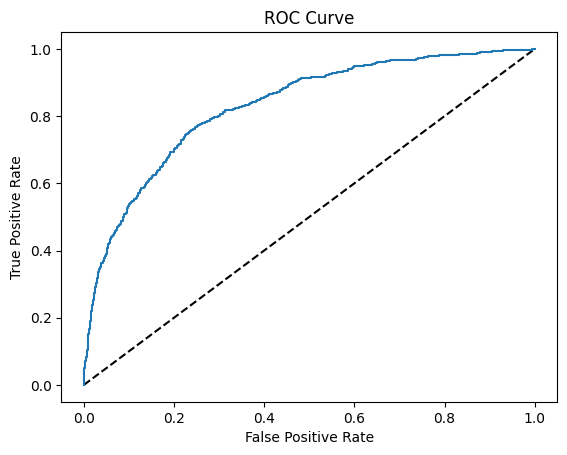

In [142]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [143]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [144]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [145]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)